# Scratch

Scratch notebook with random things in it so I don't clutter up my other notebooks!

### Fast ECDF on Non-Regular Grid

Trying to find out how we can compute our multivariate ecdfs quickly on a non-regular grid. The new way we are doing the algorithm is that we are drawing the region that we are computing the ecdf over FIRST, and then evaluating the ecdfs on these regions. However, these regions violate the regular grid assumption of the previously fast methods I've been using. What can we do instead?

#### 1. Make a regular grid out of all of the points, compute, then subset

Probably the easiest. Say we have 500 points in our region. That gives us ~500 unique X's and ~500 unique Y's: make a regular grid out of this, compute using the same methods as previously (mltools strategy), and then take only those points that were originally included in the sup region.

Benefit: we know it's ~ relatively ~ fast to compute the cdfs even on 500x500 grids, so this should be fine for now?

Con: seems kinda wasteful, but maybe the algorithmic speed up makes it worth it?

In [1]:
# function that draws a grid of points over which we wish to evaluate the sup difference between
# the true survival function and the empirical estimate
drawSupRegion <- function(dat, n_boundary_coords, n_interior_coords, gridLbs, gridUbs, p, beta) {
    
    # function that we will use our root-finding algorithm for
    empSurvFixedCoord <- function(radius, angle, prob, xCenter, yCenter) {
        xCoord <- xCenter + radius*cos(angle)
        yCoord <- yCenter + radius*sin(angle)
        exceedanceProb <- mean((dat[,1] > xCoord) & (dat[,2] > yCoord))
        return(exceedanceProb - prob)
    }
    
    radii <- rep(NA, n_boundary_coords*n_interior_coords)
    full_angles <- rep(NA, n_boundary_coords*n_interior_coords)
    angles <- seq(0, pi/2, length.out=n_boundary_coords)
    maxRad <- sqrt(sum((gridUbs-gridLbs)**2))

    # for each angle in first quadrant, find radius that gives a point with desired exceedance probability
    # by finding roots of pmvtFixedCoord given the angle
    # find both the lower and upper radius, and then store a mesh of them
    for (i in 1:n_boundary_coords) {
        angle <- angles[i]
        lower_radius <- uniroot(empSurvFixedCoord, interval=c(0, maxRad), angle=angle,
                            prob=p+beta, xCenter=gridLbs[1], yCenter=gridLbs[2])$root
        upper_radius <- uniroot(empSurvFixedCoord, interval=c(0, maxRad), angle=angle,
                             prob=p-beta, xCenter=gridLbs[1], yCenter=gridLbs[2])$root
        
        radii_per_angle <- seq(lower_radius, upper_radius, length.out=n_interior_coords)
        angles_per_angle <- rep(angle, length.out=n_interior_coords)
        
        radii[((i-1)*n_interior_coords + 1):(i*n_interior_coords)] <- radii_per_angle
        full_angles[((i-1)*n_interior_coords + 1):(i*n_interior_coords)] <- angles_per_angle
        
        
    }

    # convert back to cartesian coordinates
    X1 <- radii*cos(full_angles) + gridLbs[1]
    X2 <- radii*sin(full_angles) + gridLbs[2]
    return(data.frame(cbind(X1, X2)))
    
}

In [20]:
library(mvtnorm)
source('~/isolines_uq/scripts/R/auxiliary_scripts/utils.R')

lbs <- c(-2,-2)
ubs <- c(10, 10)
n_boundary_coords <- 50
n_interior_coords <- 4
p <- 0.1
beta <- 0.005

sample_dat <- data.frame(rmvt(100000, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))

In [21]:
start <- proc.time()
sup_reg <- drawSupRegion(sample_dat, n_boundary_coords, n_interior_coords, lbs, ubs, p, beta)
proc.time() - start

   user  system elapsed 
  2.285   0.064   2.362 

In [25]:
library(dplyr)

start <- proc.time()

sup_reg_xs_unique <- sort(unique(sup_reg$X1))
sup_reg_ys_unique <- sort(unique(sup_reg$X2))
full_grid <- expand.grid(X1=sup_reg_xs_unique, X2=sup_reg_ys_unique)
surv <- fastEmpSurv(full_grid, sample_dat)

full_surv_res <- data.table(X1=full_grid$X1, X2=full_grid$X2, surv=surv)
sup_reg <- data.table(sup_reg)

res <- full_surv_res[sup_reg, on=c('X1', 'X2')]

proc.time() - start

   user  system elapsed 
  0.220   0.001   0.123 

In [36]:
start <- proc.time()
#sample_dat <- data.frame(rmvt(10000, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
boot_dat <- sample_dat %>% sample_frac(1, replace = TRUE)
proc.time() - start

   user  system elapsed 
  0.009   0.000   0.009 

#### 2. Some kind of RCPP based approach (have the loop in a lower-level language)

In [11]:
system("echo $PATH", intern=TRUE)

[1] "/global/common/software/nersc9/jupyter/ex/25-02/nersc-utils:/opt/nersc/pe/bin:/global/common/software/nersc/bin:/global/common/software/nersc9/darshan/default/bin:/global/common/software/nersc9/sqs/2.0/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/cuda/12.2/compute-sanitizer:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/cuda/12.2/bin:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/cuda/12.2/libnvvp:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/profilers/Nsight_Compute:/opt/nvidia/hpc_sdk/Linux_x86_64/23.9/profilers/Nsight_Systems/bin:/opt/cray/pe/perftools/23.12.0/bin:/opt/cray/pe/papi/7.0.1.2/bin:/opt/cray/pe/craype/2.7.30/bin:/opt/cray/pe/mpich/8.1.28/ofi/gnu/12.3/bin:/opt/cray/pe/mpich/8.1.28/bin:/opt/cray/libfabric/1.20.1/bin:/usr/local/bin:/usr/bin:/bin:/usr/lib/mit/bin:/opt/cray/pe/bin"

In [3]:
library(Rcpp)

cppFunction(
  "NumericVector FasterLoop(NumericVector x, NumericVector y) {
  const int n = x.length();
  NumericVector z(n);
  for (int i=0; i < n; ++i) {
   z[i] = sum(x <= x[i] & y <= y[i]);
  }
  return z/n;
}")

FasterLoop(c(1,2,3), c(1,2,3))

x86_64-conda-linux-gnu-c++ -std=gnu++14 -I"/global/homes/j/jbbutler/.conda/envs/isolines/lib/R/include" -DNDEBUG   -I"/global/u1/j/jbbutler/.conda/envs/isolines/lib/R/library/Rcpp/include" -I"/tmp/RtmplvYQlL/sourceCpp-x86_64-conda-linux-gnu-1.0.10" -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /global/homes/j/jbbutler/.conda/envs/isolines/include -I/global/homes/j/jbbutler/.conda/envs/isolines/include -Wl,-rpath-link,/global/homes/j/jbbutler/.conda/envs/isolines/lib   -fpic  -fvisibility-inlines-hidden  -fmessage-length=0 -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /global/homes/j/jbbutler/.conda/envs/isolines/include -fdebug-prefix-map=/home/conda/feedstock_root/build_artifacts/r-base-split_1667676773505/work=/usr/local/src/conda/r-base-4.2.2 -fdebug-prefix-map=/global/homes/j/jbbutler/.conda/envs/isolines=/usr/local/src/conda-prefix  -c filec1dd251522e0f.cpp -o filec1dd251522e0f.o


ERROR: Error in sourceCpp(code = code, env = env, rebuild = rebuild, cacheDir = cacheDir, : Error 1 occurred building shared library.




Please install GNU development tools including a C++ compiler.




#### 3. Exploit the properties of an ecdf to solve this?

It's a step function and you are computing the differences between two step functions, and only changes when the x/y coordinates of existing points are surpassed. Further, the survival function we are comparing to is the bootstrap one, which only includes *uniquely at most* the original dataset. So, step locations shouldn't be different than the original ones. Maybe this simplification could help? Would require some thought though..

### Testing different ways of evaluating the empirical survival function an isoline

In [20]:
library(data.table)
library(mltools)

source('~/isolines_uq/scripts/R/auxiliary_scripts/distributionIsolines.R')
source('/global/homes/j/jbbutler/isolines_uq/scripts/R/auxiliary_scripts/utils.R')

In [54]:
isoline <- drawBivtIsoline(numCoords=200, gridUbs=c(10,10), gridLbs=c(-2,-2), prob=0.01)
p <- 0.01
dat <- data.frame(rmvt(100000, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))

In [45]:
start <- proc.time()
findEmpSurv <- function(row) {
    return(mean((dat[,1] > row[[1]]) & (dat[,2] > row[[2]])))
}
survs1 <- apply(isoline, 1, findEmpSurv)
proc.time() - start

   user  system elapsed 
  0.285   0.030   0.319 

In [55]:
start <- proc.time()
survs2 <- computeEmpSurvIrregular(isoline, dat)
proc.time() - start

   user  system elapsed 
  0.161   0.000   0.089 

In [51]:
dat <- data.frame(rmvt(100, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))
max(dat)

[1] 23.56424

### Empirical Isoline Test

In [12]:
source('/global/homes/j/jbbutler/isolines_uq/scripts/R/auxiliary_scripts/utils.R')

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”

Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [35]:
source('/global/homes/j/jbbutler/isolines_uq/scripts/R/auxiliary_scripts/distributionIsolines.R')
source('/global/homes/j/jbbutler/isolines_uq/scripts/R/auxiliary_scripts/utils.R')

In [29]:
dist_lst <- list()
dist_lst['hello'] <- 1
dist_lst['hello']

$hello
[1] 1

In [4]:
sample_dat <- data.frame(rmvt(100000, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))

In [10]:
res <- drawEmpiricalIsoline(sample_dat, 100, c(-2,-2), c(100,100), 0.01)

In [58]:
a <- readRDS('/pscratch/sd/j/jbbutler/bootstrap_c/bivt/p0.05_alpha0.05_n10000.RData')

In [30]:
a <- readRDS('/pscratch/sd/j/jbbutler/true_cs/bivt/p0.1/n1000.RData')

In [50]:
samplingFunc <- loadSamplingFunction(dist='bivt')
isoline <- drawIsoline(dist='bivt', numCoords=200, gridUbs=c(20,20), gridLbs=c(-2,-2), prob=0.05)
n <- 1000000
p <- 0.05

In [55]:
parallelizedCode <- function(ind) {

    dat <- samplingFunc(n)
    est_survfunc <- computeEmpSurvIrregular(isoline, dat)
    monte_carlo <- max(abs(est_survfunc - p))

    #return(monte_carlo)
}

In [58]:
start <- proc.time()
parallelizedCode(1)
proc.time() - start

   user  system elapsed 
  1.044   0.160   0.804 

In [30]:
library(mvtnorm)
dat <- data.frame(rmvt(100000, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))

In [31]:
source('~/isolines_uq/scripts/R/confidence_regions_procedure/confidenceRegions.R')

In [32]:
start <- proc.time()
res <- drawBaseRegionsBetaZero(dat, c(0.01, 0.05, 0.1), 0.05, 1000, c(-2,-2))
end <- proc.time()

In [29]:
end - start

   user  system elapsed 
170.634   0.344 103.661 

In [33]:
a <- readRDS('/pscratch/sd/j/jbbutler/bootstrap_c_tubes/dist/p0.1/n10000_tubes.RData')

In [ ]:
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/utils.R')

library(mvtnorm)
dat <- data.frame(rmvt(10000, sigma = matrix(c(1, 0.7, 0.7, 1), nrow = 2), df = 4))

In [64]:


emp_isoline <- drawEmpiricalIsoline(dat=dat, n_coords=200, gridLbs=c(-10,-10), gridUbs=c(max(dat), max(dat)), 0.0002)

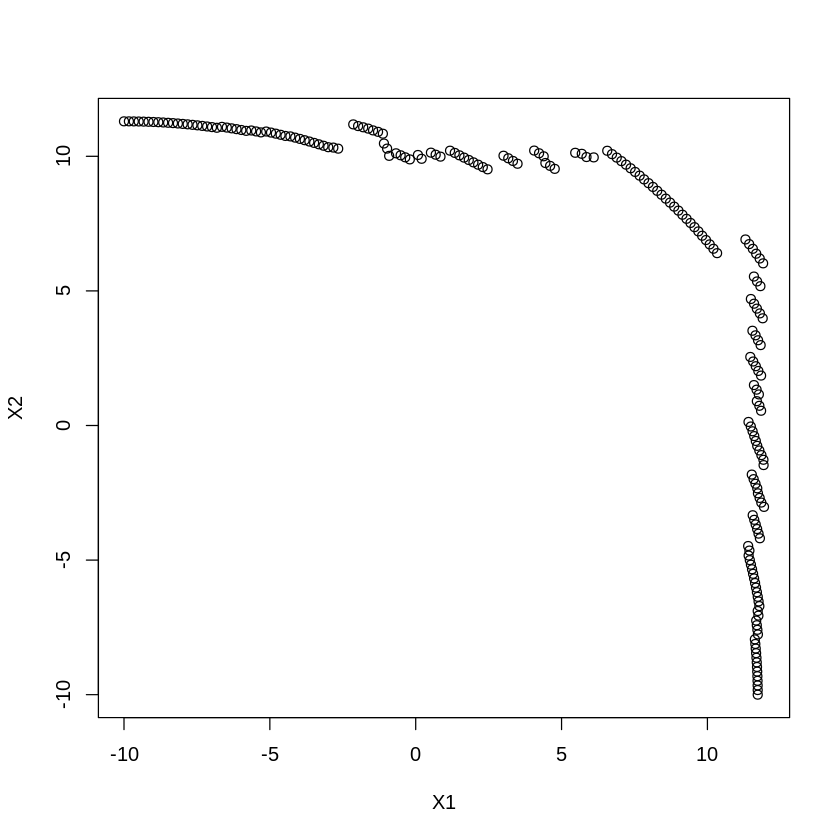

In [65]:
plot(emp_isoline)

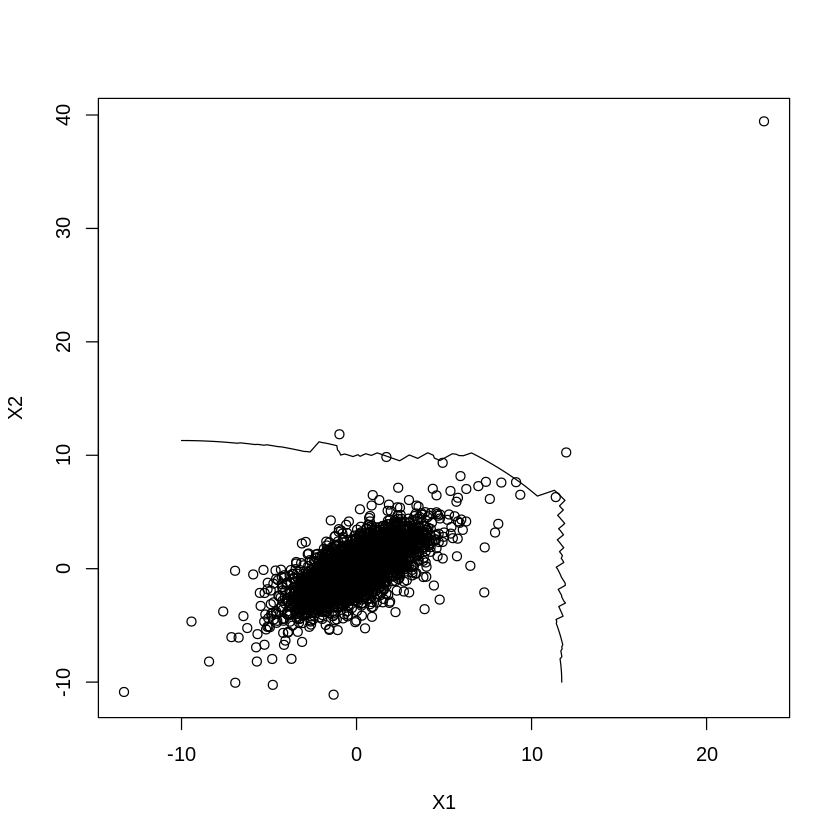

In [66]:
plot(dat)
lines(emp_isoline)

### Drawing from a Distribution that is Regularly Varying

In [2]:
library(dplyr)
library(mvtnorm)
library(mnormt)
library(foreach)
library(doSNOW)
library(parallel)

source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/utils.R')
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/distributionIsolines.R')

# simulation parameters
## sample sizes to try
ns <- c(1000, 5000, 10000, 50000)
## rate at which we look out into the tail (q_n = n^-gamma)
gamma <- 1/2
## extreme value index of probability distribution
xi <- 1/4
## sequence of extreme probabilities
pn <- function(n) { 5/n }
plab <- '5_div_n'
dists <- c('bivt')
n_monte_carlo <- 10000

# parallelization specs
n_cores <- 64

save_path <- '/pscratch/sd/j/jbbutler/true_cs/'

# function to take care of the parallelization
parallelizedCode <- function(ind) {

    dat <- samplingFunc(n)
    est_survfunc <- apply(isoline, 1, blendedSurvivalFunc, dat=dat, gamma=gamma, xi=xi)
    monte_carlo <- max(abs(est_survfunc - p))

    return(monte_carlo)
}

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘mnormt’ was built under R version 4.2.3”
Warning message:
“package ‘foreach’ was built under R version 4.2.3”
Loading required package: iterators

Warning message:
“package ‘iterators’ was built under R version 4.2.3”
Loading required package: snow

Warning message:
“package ‘snow’ was built under R version 4.2.3”

Attaching package: ‘parallel’


The following objects are masked from ‘package:snow’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster


Warning message:
“package ‘purrr’ was built under R version 4.2.3”

Attaching package: ‘purr

In [5]:
samplingFunc <- loadSamplingFunction(dist='bivt')

In [40]:
n <- 50000
p <- 5/n
isoline <- drawIsoline(dist='bivt', numCoords=200, gridUbs=c(50,50), gridLbs=c(0,0), prob=p)

In [41]:
start <- proc.time()
a <- parallelizedCode(1)
end <- proc.time()

In [42]:
end-start

   user  system elapsed 
  2.501   0.577   3.080 

In [30]:
0.15*10000/64

[1] 23.4375

In [35]:
0.4*10000/64

[1] 62.5

In [39]:
0.5*10000/64

[1] 78.125

In [43]:
4*10000/64

[1] 625

In [37]:

n <- 50000
p <- 5/n

start <- proc.time()

dat <- samplingFunc(n)
ext_isoline <- drawExtremeIsoline(dat, p, n_coords=200, gridLbs=c(0,0), gamma, xi)

end <- proc.time()
end-start

   user  system elapsed 
  3.281   0.028   3.397 

In [38]:
start <- proc.time()
boot_dat <- samplingFunc(n)
est_survfunc <- apply(ext_isoline, 1, blendedSurvivalFunc, dat=boot_dat, gamma=gamma, xi=xi)
boot_process <- max(abs(est_survfunc - p))
end <- proc.time()
end-start

   user  system elapsed 
  2.770   0.044   2.858 

In [18]:
0.2*1000*500/64/60

[1] 26.04167

In [23]:
0.6*1000*500/64/60

[1] 78.125

In [29]:
0.6*1000*500/64/60

[1] 78.125

In [39]:
4*1000*500/64/60

[1] 520.8333

In [40]:
520/60

[1] 8.666667

In [5]:
dat <- readRDS('/pscratch/sd/j/jbbutler/extreme_trueboot_c_tubes/bivt/n10000_p5_div_n.RData')

In [3]:
library(mvtnorm)
library(ggplot2)

In [8]:
dat <- data.frame(rmvt(n=10000, sigma=matrix(c(1, 0.4, 0.4, 1), nrow=2), df=4))

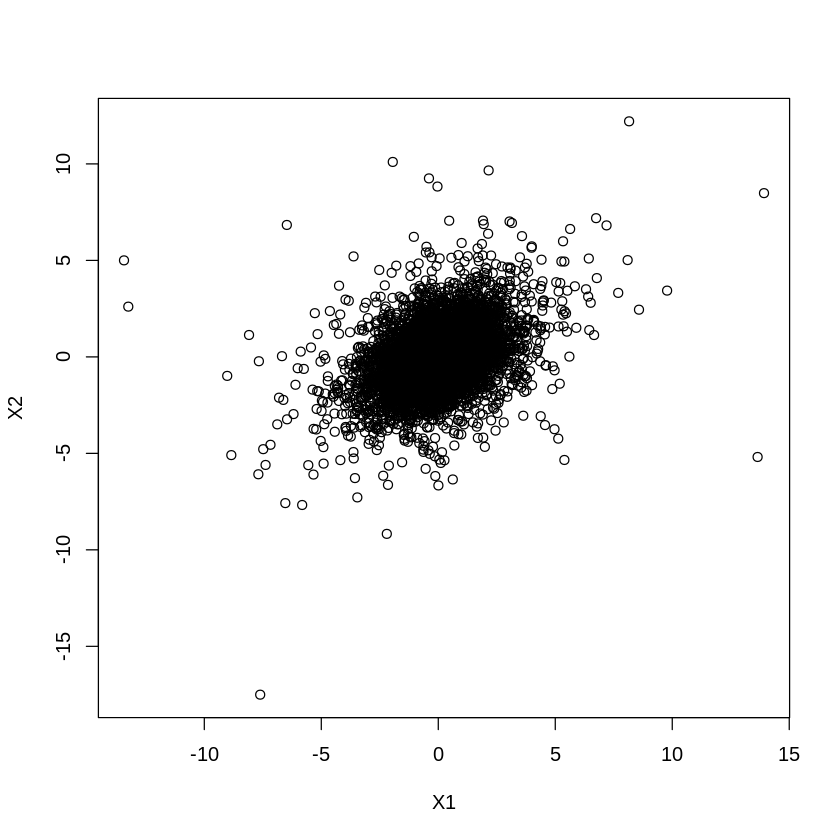

In [9]:
plot(dat)

In [26]:
alpha <- 1

margY1 <- (1-pt(dat$X1, df=4))^(-1/alpha)
margY2 <- (1-pt(dat$X2, df=4))^(-1/alpha)
Y <- data.frame(Y1=margY1, Y2=margY2)

In [31]:
Y - 1

Y1,Y2
<dbl>,<dbl>
0.07526256,0.17261522
0.02131499,0.01103955
0.41051997,0.14747675
6.16250130,8.87448212
4.17149202,45.26163044
0.38110684,0.15957326
15.62027933,1.88267295
0.93820830,0.75228322
0.49863337,0.41366445


In [36]:
ns <- round(exp(seq(7, 12)))
ns

[1]   1097   2981   8103  22026  59874 162755

In [1]:
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/confidenceRegions.R')

rdist <- function(n) {
    dat <- data.frame(rmvt(n=n, sigma=matrix(c(1, 0.7, 0.7, 1), nrow=2), df=1))
    margY1 <- (1-pt(dat$X1, df=1))^(-1)
    margY2 <- (1-pt(dat$X2, df=1))^(-1)
    Y <- data.frame(Y1=margY1, Y2=margY2) - 1

    return(Y)
}

Warning message:
“package ‘ks’ was built under R version 4.2.3”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: mgcv

Warning message:
“package ‘mgcv’ was built under R version 4.2.3”
Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.

Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”

Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last




In [3]:
gamma <- 1/2
xi <- 1
n <- 5000
B <- 1
p <- 5/n
dat <- rdist(n)
alphas <- c(0.05)
regions <- drawExtremeRegionsBetaZero(dat, alphas, p, B, gamma, xi)

In [5]:
dat

Y1,Y2
<dbl>,<dbl>
0.121449378,0.106465764
2.189809335,2.289530948
0.776344645,0.903134839
3.575134791,3.674429707
0.153016256,0.196643870
1.233031952,0.478012518
1.511504038,1.179299061
0.533464124,0.620340250
5.852414649,7.205482074


In [1]:
a <- readRDS('/pscratch/sd/j/jbbutler/extreme_bootstrap_c_tubes/bivt_copula_pareto_margins/p5_div_n/n1000_tubes.RData')

In [3]:
a[[2]]

Y1,Y2
<dbl>,<dbl>
0.958184896,1.246759599
1.516869383,0.480376961
0.936759772,2.697683589
19.006403119,0.169265930
0.121018998,0.168230207
1.042724544,0.726785941
0.013498613,0.009672156
0.535363810,0.614041556
1.805791126,0.992561266


In [1]:
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/distributionIsolines.R')

In [35]:
p <- 5/50000
res <- drawBivtIsoline(200, c(10000,10000), c(-100,-100), p, df=1)

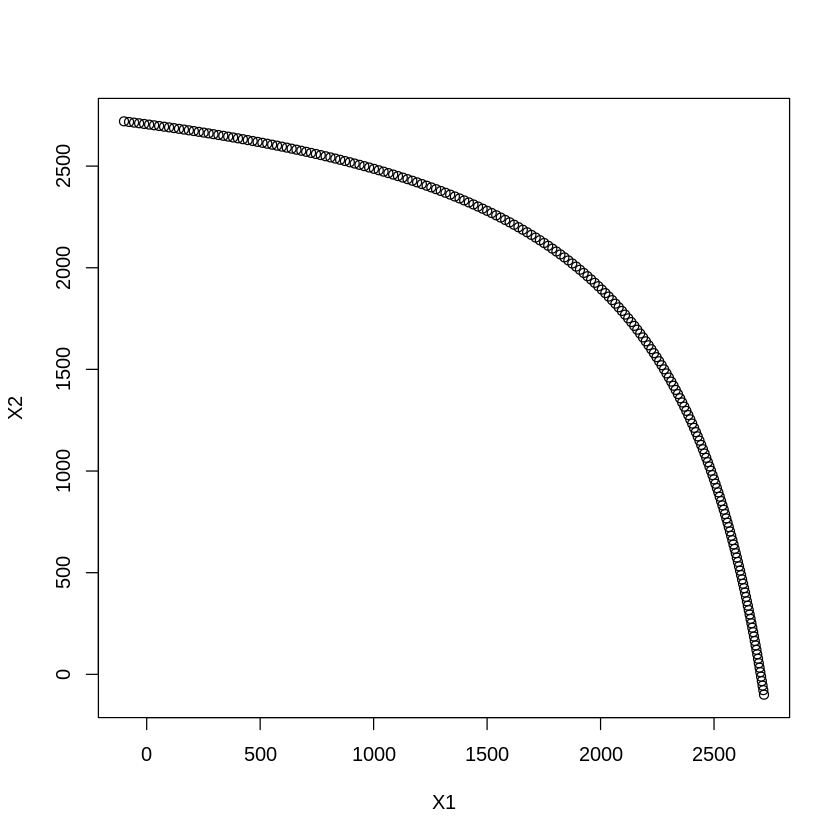

In [36]:
plot(res)

In [37]:
unifX1 <- (1/(1-pt(res$X1, df=1)))-1
unifX2 <- (1/(1-pt(res$X2, df=1)))-1


In [38]:
iso <- data.frame(X1=unifX1, X2=unifX2)

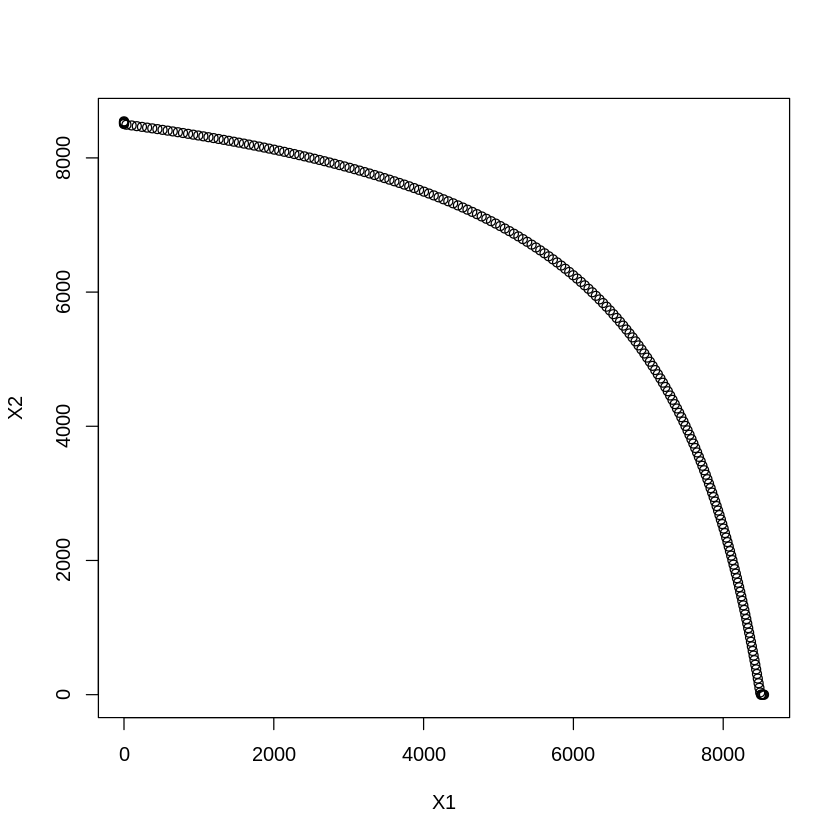

In [39]:
plot(iso)

In [7]:
res <- drawParetoBivtIsoline(1000, c(10000, 10000), c(0,0), 10**(-4), 1)

In [9]:
save_path <- '/pscratch/sd/j/jbbutler/extreme_bootstrap_c_tubes/'
dists <- c('bivt_copula_pareto_margins')
p_labs <- c('p5_div_n')

In [9]:
## marginal transformations
X <- rt(1000, df=1)
gamma <- 1/2

In [13]:
library(ismev)
library(evd)

Loading required package: mgcv

Warning message:
“package ‘mgcv’ was built under R version 4.2.3”
Loading required package: nlme

This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.

Warning message:
“package ‘evd’ was built under R version 4.2.3”


In [41]:
est_cdf <- function(x, dat, gamma) {
    edf <- ecdf(dat)
    edf_vals <- edf(x)
    threshold_prob <- length(dat)^(-gamma)
    threshold <- quantile(dat, 1-threshold_prob)
    x_gpd <- x[x > threshold]
    gpdOut <- ismev::gpd.fit(dat,
					threshold = threshold, show = F)
    gpd_probs <- 1-(1-evd::pgpd(x_gpd, loc = gpdOut$threshold, scale = gpdOut$mle[1], shape = gpdOut$mle[2]))*(threshold_prob)
    edf_vals[x > threshold] <- gpd_probs
    return(edf_vals)   
}

In [81]:
est_inv_cdf <- function(p, dat, gamma) {

    threshold_prob <- length(dat)^(-gamma)
    threshold <- as.numeric(quantile(dat, 1-threshold_prob))
    quantiles <- as.numeric(quantile(dat, p))
    gpd_probs <- p[p > 1-threshold_prob]
    gpdOut <- ismev::gpd.fit(dat,
					threshold = threshold, show = F)
    quantiles[p > 1-threshold_prob] <- evd::qgpd(1-((1-gpd_probs)/threshold_prob), loc = gpdOut1$threshold, scale = gpdOut1$mle[1], shape = gpdOut1$mle[2])
    quantiles <- as.numeric(quantiles)
    return(quantiles)

}

In [107]:
X <- rt(100, df=1)
gamma <- 1/2

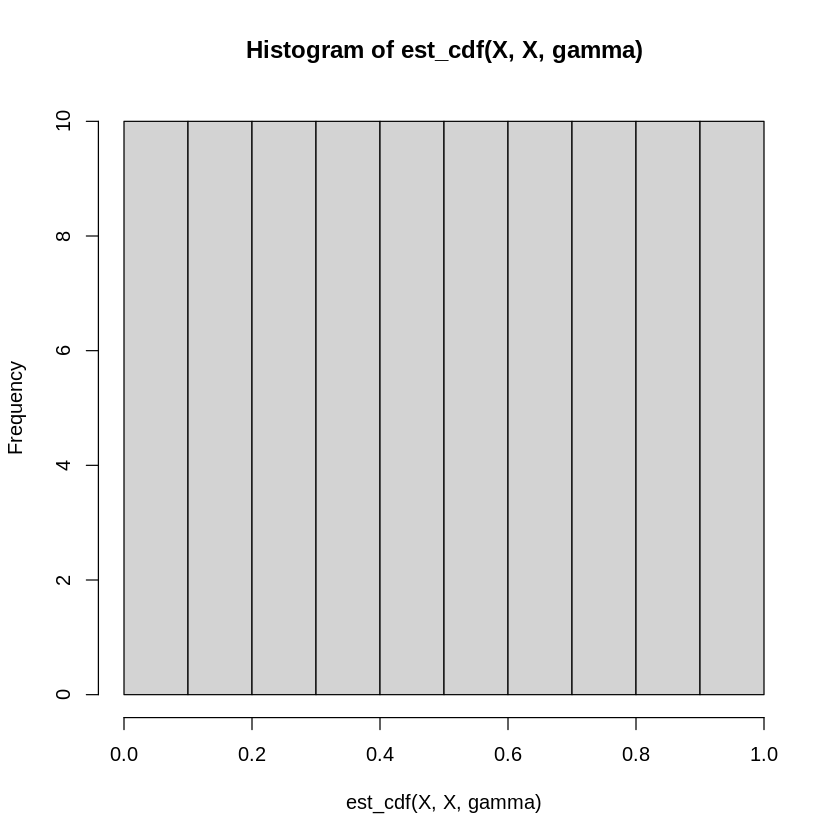

In [108]:
hist(est_cdf(X, X, gamma))

In [1]:
library(foreach)
library(doSNOW)
library(parallel)
library(dplyr)
library(mvtnorm)

source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/distributionIsolines.R')
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/utils.R')
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/confidenceRegions.R')

Warning message:
“package ‘foreach’ was built under R version 4.2.3”
Loading required package: iterators

Warning message:
“package ‘iterators’ was built under R version 4.2.3”
Loading required package: snow

Warning message:
“package ‘snow’ was built under R version 4.2.3”

Attaching package: ‘parallel’


The following objects are masked from ‘package:snow’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, clusterSplit, makeCluster, parApply,
    parCapply, parLapply, parRapply, parSapply, splitIndices,
    stopCluster


Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘purrr’ was built under R version 4.2.3”

Attaching package: ‘purrr’


The following objects are masked from ‘package:foreach’:

    a

In [5]:
rdist <- function(n) {
    dat <- data.frame(rmvt(n=n, sigma=matrix(c(1, 0.7, 0.7, 1), nrow=2), df=1))
    return(dat)
}

ns <- c(1000, 5000, 10000, 50000)
dist <- 'copula_tdf1_marginals_tdf1'
alphas <- c(0.05, 0.1, 0.01)
gamma <- 1/2
xi <- 1
pn <- function(n) { 5/n }

# number of cores for parallelization
n_cores <- 64
# number of simulations, i.e. number of bootstrap estimates of c_{1-alpha}
n_sims <- 500
# number of bootstrap replicates
B <- 10

numCoords <- 200
ub <- max(qt(1-(5/ns), df=1) + 100)
lvlset_ubs <- c(ub, ub)
lvlset_lbs <- c(0, 0)

In [10]:
start <- proc.time()
n <- ns[4]
p <- 5/n

dat <- rdist(n)

transform <- function(pts, dat) {
        transformed_pts <- 1/(1-est_cdf(pts, dat, gamma)) - 1
        return(transformed_pts)
    }
    
    transformed_dat_X1 <- transform(dat[,1], dat[,1])
    transformed_dat_X2 <- transform(dat[,2], dat[,2])
    transformed_dat <- data.frame(X1=transformed_dat_X1, X2=transformed_dat_X2)
    
    regions <- drawExtremeRegion(transformed_dat, alphas, p, B, gamma, xi)

    # evaluate coverage
    #transformed_isoline <- data.frame(X1=transform(isoline[,1], dat[,1]), X2=transform(isoline[,2], dat[,2]))
    #est_survfunc <- apply(transformed_isoline, 1, blendedSurvivalFunc, dat=transformed_dat, gamma=gamma, xi=xi)

In [9]:
ub

[1] 3283.099

In [13]:
library(foreach)
library(doSNOW)
library(parallel)
library(dplyr)
library(mvtnorm)

source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/distributionIsolines.R')
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/utils.R')
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/confidenceRegions.R')

save_path <- '/pscratch/sd/j/jbbutler/extreme_tubes/rv_index_unknown/'

rdist <- function(n) {
    dat <- data.frame(rmvt(n=n, sigma=matrix(c(1, 0.7, 0.7, 1), nrow=2), df=1))
    return(dat)
}

ns <- c(1000, 5000, 10000)
dist <- 'copula_tdf1_marginals_tdf1'
alphas <- c(0.05, 0.1, 0.01)
gamma <- 1/2
xi <- 1
pn <- function(n) { 5/n }

# number of cores for parallelization
n_cores <- 64
# number of simulations, i.e. number of bootstrap estimates of c_{1-alpha}
n_sims <- 500
# number of bootstrap replicates
B <- 10

## Parameters for drawing isolines to check coverage
# number of coords for isoline drawing
numCoords <- 200
ub <- max(qt(1-(5/ns), df=1) + 100)
lvlset_ubs <- c(ub, ub)
lvlset_lbs <- c(0, 0)

In [14]:
# part of loop that will be parallelized: the computation of c for each simulation and evaluation of coverage
parallelizedCode <- function(ind) {

    dat <- rdist(n)
    # convert marginals to be draws from a lomax distribution (pareto starting at 0)
    # shape and scale both 1

    transform <- function(pts, dat) {
        transformed_pts <- 1/(1-est_cdf(pts, dat, gamma)) - 1
        return(transformed_pts)
    }
    
    transformed_dat_X1 <- transform(dat[,1], dat[,1])
    transformed_dat_X2 <- transform(dat[,2], dat[,2])
    transformed_dat <- data.frame(X1=transformed_dat_X1, X2=transformed_dat_X2)
    
    regions <- drawExtremeRegion(transformed_dat, alphas, p, B, gamma, xi)

    # evaluate coverage
    transformed_isoline <- data.frame(X1=transform(isoline[,1], dat[,1]), X2=transform(isoline[,2], dat[,2]))
    est_survfunc <- apply(transformed_isoline, 1, blendedSurvivalFunc, dat=transformed_dat, gamma=gamma, xi=xi)
    is_covereds <- list()
    cs <- regions$c_estimates

    for (i in 1:length(alphas)) {
        alpha <- alphas[i]
        c <- cs[[as.character(alpha)]]
        is_covereds[as.character(alpha)] <- all((est_survfunc <= p + c) & (est_survfunc >= p - c))
    }
    regions$is_covereds <- is_covereds
    return(regions)
}


In [ ]:
#sampling_func <- loadSamplingFunction(dist)
distpath <- paste0(save_path, dist, '/')
dir.create(distpath)

ppath <- paste0(distpath, 'p5_div_n/')
dir.create(ppath)

n <- ns[1]
p <- pn(n)

isoline <- drawBivtIsoline(numCoords=numCoords, gridUbs=lvlset_ubs, gridLbs=lvlset_lbs, prob=p, df=1)

for (i in 1:500) {

    a <- parallelizedCode(1)

}

Warning message in dir.create(distpath):
“'/pscratch/sd/j/jbbutler/extreme_tubes/rv_index_unknown/copula_tdf1_marginals_tdf1' already exists”
Warning message in dir.create(ppath):
“'/pscratch/sd/j/jbbutler/extreme_tubes/rv_index_unknown/copula_tdf1_marginals_tdf1/p5_div_n' already exists”


In [34]:
a <- readRDS('/pscratch/sd/j/jbbutler/extreme_tubes/rv_index_unknown/copula_tdf1_marginals_tdf1/p5_div_n/n1000_tubes.RData')

In [35]:
is_infs <- rep(NA, length(a))
is_nans <- rep(NA, length(a))

for (i in 1:length(a)) {
    df <- a[[i]]
    
}

In [56]:
a[[20]]$is_covereds

$`0.05`
[1] TRUE

$`0.1`
[1] TRUE

$`0.01`
[1] TRUE

In [50]:
lst <- vector(mode='list', length=length(a))
for (i in 1:length(a)) {

    lst[[i]] <- a[[i]]$c_estimates

}

In [3]:
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/distributionIsolines.R')
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/utils.R')
source('~/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/confidenceRegions.R')

rdist <- function(n) {
    dat <- data.frame(rmvt(n=n, sigma=matrix(c(1, 0.7, 0.7, 1), nrow=2), df=1))
    return(dat)
}

n <- 1000
gamma <- 1/2
n_reps <- 100000
is_inf <- rep(NA, n_reps)
is_nan <- rep(NA, n_reps)

for (i in 1:n_reps) {
    dat <- rdist(n)

    transform <- function(pts, dat) {
        transformed_pts <- 1/(1-est_cdf(pts, dat, gamma)) - 1
        return(transformed_pts)
    }

    transformed_dat_X1 <- transform(dat[,1], dat[,1])
    transformed_dat_X2 <- transform(dat[,2], dat[,2])
    is_inf[i] <- any(is.infinite(c(transformed_dat_X1, transformed_dat_X2)))
    is_nan[i] <- any(is.nan(c(transformed_dat_X1, transformed_dat_X2)))
    
}

Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘purrr’ was built under R version 4.2.3”
Warning message:
“package ‘data.table’ was built under R version 4.2.3”

Attaching package: ‘data.table’


The following object is masked from ‘package:purrr’:

    transpose


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: mgcv

Warning message:
“package ‘mgcv’ was built under R version 4.2.3”
Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-42. For overview type 'help("mgcv-package")'.

Warning message:
“package ‘evd’ was built under R version 4.2.3”
Warning message:
“package ‘ks’ was built under R

In [22]:
blendedSurvivalFunc <- function(pt, dat, gamma, xi) {

    qn <- nrow(dat)^(-gamma)
    empsurv_prob <- mean((dat[,1] > pt[1]) & (dat[,2] > pt[2]))

    if (empsurv_prob >= qn) {
        return(empsurv_prob)
    }
    else {
        theta <- atan(pt[2]/pt[1])
        empsurvDiff <- function(r) { return(mean((dat[,1] > r*cos(theta)) & (dat[,2] > r*sin(theta)))-qn) }
        rp <- sqrt(pt[2]**2 + pt[1]**2)
        rq <- uniroot(empsurvDiff, interval=c(0, rp))$root

        return(((rq/rp)^(1/xi))*qn)
    }
}


In [25]:
gamma <- 1/2
xi <- 1
dat <- rdist(n)
pt <- c(20, 20)

In [26]:
blendedSurvivalFunc(pt, dat, gamma, xi)

[1] 0.007513188

In [12]:
rp

ERROR: Error in eval(expr, envir, enclos): object 'rp' not found


In [2]:
dat <- rt(1000, df=1)

In [5]:
obj <- ecdf(dat)

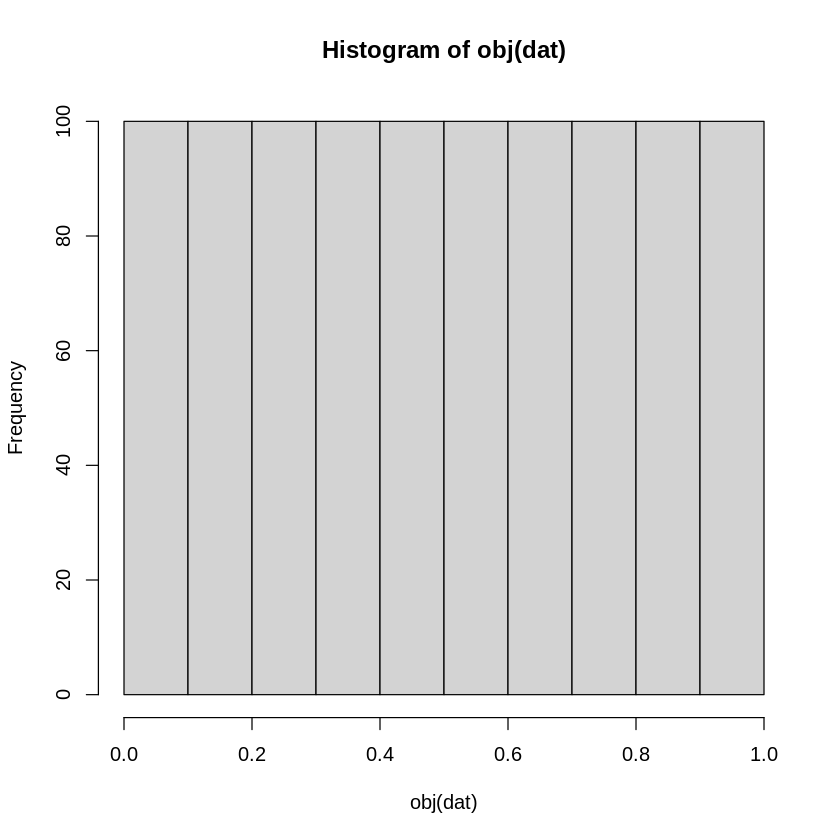

In [8]:
hist(obj(dat))

In [9]:
readRDS('/pscratch/sd/j/jbbutler/extreme_tubes/marginals_unknown_edf_only/copula_tdf1_marginals_tdf1/p5_div_n/n1000_tubes.RData')

[[1]]
<simpleError in uniroot(empSurvFixedCoord, interval = c(0, maxRad), angle = angles[i],     prob = p, xCenter = gridLbs[1], yCenter = gridLbs[2]): invalid 'xmax' value>

[[2]]
<simpleError in uniroot(empSurvFixedCoord, interval = c(0, maxRad), angle = angles[i],     prob = p, xCenter = gridLbs[1], yCenter = gridLbs[2]): invalid 'xmax' value>

[[3]]
<simpleError in uniroot(empSurvFixedCoord, interval = c(0, maxRad), angle = angles[i],     prob = p, xCenter = gridLbs[1], yCenter = gridLbs[2]): invalid 'xmax' value>

[[4]]
<simpleError in uniroot(empSurvFixedCoord, interval = c(0, maxRad), angle = angles[i],     prob = p, xCenter = gridLbs[1], yCenter = gridLbs[2]): invalid 'xmax' value>

[[5]]
<simpleError in uniroot(empSurvFixedCoord, interval = c(0, maxRad), angle = angles[i],     prob = p, xCenter = gridLbs[1], yCenter = gridLbs[2]): invalid 'xmax' value>

[[6]]
<simpleError in uniroot(empSurvFixedCoord, interval = c(0, maxRad), angle = angles[i],     prob = p, xCenter = gridLbs[

In [111]:
set.seed(12345)
source('/global/homes/j/jbbutler/isolines_uq/scripts/R/confidence_regions_procedure/auxiliary_scripts/utils.R')
library(mvtnorm)

In [144]:
rdist <- function(n) {
    dat <- data.frame(rmvt(n=n, sigma=matrix(c(1, 0.7, 0.7, 1), nrow=2), df=1))
    return(dat)
}
dat <- rdist(1000)

transform <- function(pts, dat) {
    edf <- ecdf(dat)
    transformed_pts <- 1/(1-edf(pts)) - 1
    return(transformed_pts)
}

transformed_dat_X1 <- transform(dat[,1], dat[,1])
transformed_dat_X2 <- transform(dat[,2], dat[,2])
transformed_dat <- data.frame(X1=transformed_dat_X1, X2=transformed_dat_X2)

emp_iso <- drawEmpiricalIsoline(transformed_dat, 200, c(0,0), nrow(dat)^(-gamma))


ERROR: Error in uniroot(empSurvFixedCoord, interval = c(0, maxRad), angle = angles[i], : invalid 'xmax' value


In [134]:
# function that we will use our root-finding algorithm for
empSurvFixedCoord <- function(radius, angle, prob, xCenter, yCenter) {
        xCoord <- xCenter + radius*cos(angle)
        yCoord <- yCenter + radius*sin(angle)
        exceedanceProb <- mean((dat[,1] > xCoord) & (dat[,2] > yCoord))
        return(exceedanceProb - prob)
}

In [135]:
dat <- transformed_dat

n_coords <- 200
gridLbs <- c(0,0)
p <- nrow(dat)^(-gamma)

radii <- rep(NA, n_coords)
angles <- seq(0, pi/2, length.out=n_coords)
max_dat_r <- max(10 + sqrt((dat[,1]**2) + (dat[,2]**2)))
gridUbs <- c(max_dat_r, max_dat_r)
maxRad <- sqrt(sum((max_dat_r-gridLbs)**2))

In [136]:
# for each angle in first quadrant, find radius that gives a point with desired exceedance probability
# by finding roots of pmvtFixedCoord given the angle
# find both the lower and upper radius, and then store a mesh of them
for (i in 1:n_coords) {
    radii[i] <- uniroot(empSurvFixedCoord, interval=c(0, maxRad), angle=angles[i],
                             prob=p, xCenter=gridLbs[1], yCenter=gridLbs[2])$root
}

# convert back to cartesian coordinates
X1 <- radii*cos(angles) + gridLbs[1]
X2 <- radii*sin(angles) + gridLbs[2]

ERROR: Error in uniroot(empSurvFixedCoord, interval = c(0, maxRad), angle = angles[i], : invalid 'xmax' value


In [141]:
which.max(dat[,2])

[1] 299

,X1,X2
,<dbl>,<dbl>
299,499,Inf


In [147]:
edf <- ecdf(dat[,1])


In [150]:
max(edf(dat[,1]))

[1] 1

In [34]:
dat <- rt(n=1000000, df=1)
pts <- seq(-15, 15, length.out=300)
est <- kcde(x=dat, eval.points=pts)$estimate
true <- pt(pts, df=1)
df <- data.frame(x=pts, est=est, true=true)

In [35]:
library(ggplot2)

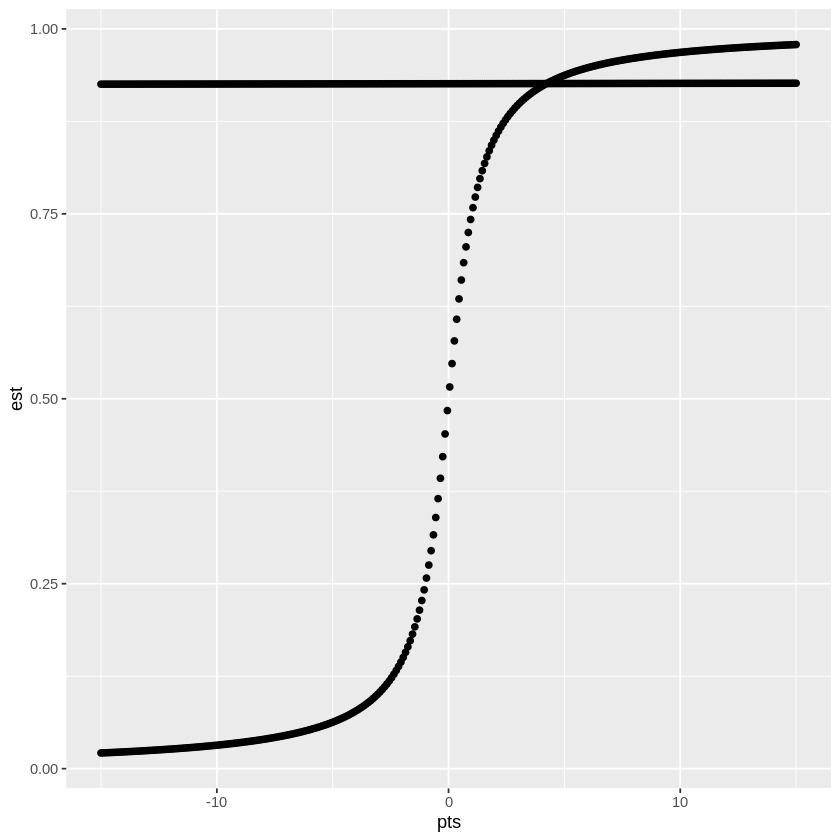

In [36]:
ggplot(df) + geom_point(aes(x=pts, est)) + geom_point(aes(x=pts, true))

In [39]:
res <- readRDS('/pscratch/sd/j/jbbutler/extreme_tubes/diagnosing_undercoverage/copula_tdf1_marginals_tdf1/p5_div_n/n10000_tubes_410.RData')

In [44]:
res$regions_ecdf

X1,X2
<dbl>,<dbl>
1.28832952,1.49625562
7.23045267,4.04540868
0.20062432,0.16686114
3.64037123,2.77073906
0.27616131,0.17522623
7.14332248,1.34962406
0.95848022,0.49902563
0.24719381,0.25062531
0.06213489,0.09039363


In [43]:
res$orig_dat

X1,X2
<dbl>,<dbl>
0.18698956,0.30845282
2.41560590,1.30853429
-1.83677232,-2.22599639
1.23446879,0.86002779
-1.30821826,-2.09220809
2.39140284,0.22743851
-0.04368101,-0.58019031
-1.47621129,-1.40862323
-5.61287649,-4.09453583
